## Modified introduction using forex data

This is the trading rule example shown in [the introduction](https://github.com/robcarver17/pysystemtrade/blob/master/docs/introduction.md) but modified to use Interactive Brokers instead of CSV files as data source.  

IB requires a minimum equity and a monthly subscription to provide historical data on future contracts.  This example was modified to use FX prices instead futures to make it runnable with free unfunded paper trading accounts.  Note that Rob [does not recommend trading FX spot data with IB due to their high fees](https://github.com/robcarver17/pysystemtrade/issues/517#issuecomment-1010770678).

First, import the required packages and initialize ib_insync.  

In [1]:
from sysbrokers.IB.ib_connection import connectionIB
from sysbrokers.IB.ib_Fx_prices_data import ibFxPricesData

from ib_insync import util
util.startLoop() #only required when running inside a notebook

Configuring sim logging


Connecting to Interactive Brokers gateway...

In [4]:
conn = connectionIB(111,ib_ipaddress = "127.0.0.1", ib_port=7497)
conn

2024-12-22 22:53:40 ERROR connectionIB {'type': 'connectionIB', 'broker': 'IB', 'clientid': 111} Broker account ID not found in private config - may cause issues


IB broker connection{'ipaddress': '127.0.0.1', 'port': 7497, 'client': 111}

See what fx instruments we have configured.  These are configured in `sysbrokers/IB/ib_config_spot_FX.csv`

In [10]:
from sysdata.data_blob import dataBlob
data = dataBlob()
ibfxpricedata = ibFxPricesData(conn,data=data)
ibfxpricedata.get_list_of_fxcodes()

['AUDUSD',
 'CADUSD',
 'CHFUSD',
 'EURUSD',
 'GBPUSD',
 'HKDUSD',
 'JPYUSD',
 'KRWUSD',
 'CNHUSD',
 'SGDUSD',
 'MXPUSD',
 'SEKUSD']

Now we select one instrument (`EURUSD`) and try to fetch historical data for it.

In [11]:
ibfxpricedata.get_fx_prices('EURUSD')

2024-12-22 23:01:41 DEBUG ibFxPricesData {'currency_code': 'EURUSD'} Updating log attributes
2024-12-22 23:01:42 DEBUG ibFxPricesData Log attributes reset
2024-12-22 23:01:42 DEBUG ibFxPricesData {'currency_code': 'EURUSD'} Downloaded 259 prices


2024-12-22 23:01:41 DEBUG ibFxPricesData {'currency_code': 'EURUSD'} Reqid -1: 2106 HMDS data farm connection is OK:cashhmds for None


index
2023-12-22 23:00:00    1.10125
2023-12-26 23:00:00    1.10425
2023-12-27 23:00:00    1.11050
2023-12-28 23:00:00    1.10610
2023-12-29 23:00:00    1.10410
                        ...   
2024-12-16 23:00:00    1.05110
2024-12-17 23:00:00    1.04915
2024-12-18 23:00:00    1.03530
2024-12-19 23:00:00    1.03620
2024-12-20 23:00:00    1.04270
Name: FINAL, Length: 259, dtype: float64

Data can also be indexed as a python dict:

In [12]:
ibfxpricedata['JPYUSD']

2024-12-22 23:02:04 DEBUG ibFxPricesData {'currency_code': 'USDJPY'} Updating log attributes
2024-12-22 23:02:04 DEBUG ibFxPricesData Log attributes reset
2024-12-22 23:02:04 DEBUG ibFxPricesData {'currency_code': 'JPYUSD'} Downloaded 259 prices


index
2023-12-22 23:00:00    0.007019
2023-12-26 23:00:00    0.007022
2023-12-27 23:00:00    0.007051
2023-12-28 23:00:00    0.007071
2023-12-29 23:00:00    0.007093
                         ...   
2024-12-16 23:00:00    0.006489
2024-12-17 23:00:00    0.006517
2024-12-18 23:00:00    0.006463
2024-12-19 23:00:00    0.006352
2024-12-20 23:00:00    0.006392
Name: FINAL, Length: 259, dtype: float64

Create the trading rule

In [13]:
import pandas as pd
from sysquant.estimators.vol import robust_vol_calc


def calc_ewmac_forecast(price, Lfast, Lslow=None):
    """
    Calculate the ewmac trading rule forecast, given a price and EWMA speeds Lfast, Lslow and vol_lookback

    """
    if Lslow is None:
        Lslow = 4 * Lfast

    ## We don't need to calculate the decay parameter, just use the span directly
    fast_ewma = price.ewm(span=Lfast).mean()
    slow_ewma = price.ewm(span=Lslow).mean()
    raw_ewmac = fast_ewma - slow_ewma

    vol = robust_vol_calc(price.diff())

    return raw_ewmac / vol

Run a forecast with the previous rule

In [14]:
price=ibfxpricedata['EURUSD']
ewmac=calc_ewmac_forecast(price, 32, 128)
ewmac.tail(5)

2024-12-22 23:04:05 DEBUG ibFxPricesData {'currency_code': 'EURUSD'} Updating log attributes
2024-12-22 23:04:05 DEBUG ibFxPricesData Log attributes reset
2024-12-22 23:04:05 DEBUG ibFxPricesData {'currency_code': 'EURUSD'} Downloaded 259 prices


index
2024-12-16 23:00:00   -4.014271
2024-12-17 23:00:00   -4.160225
2024-12-18 23:00:00   -3.670773
2024-12-19 23:00:00   -3.881311
2024-12-20 23:00:00   -3.821591
Name: FINAL, dtype: float64

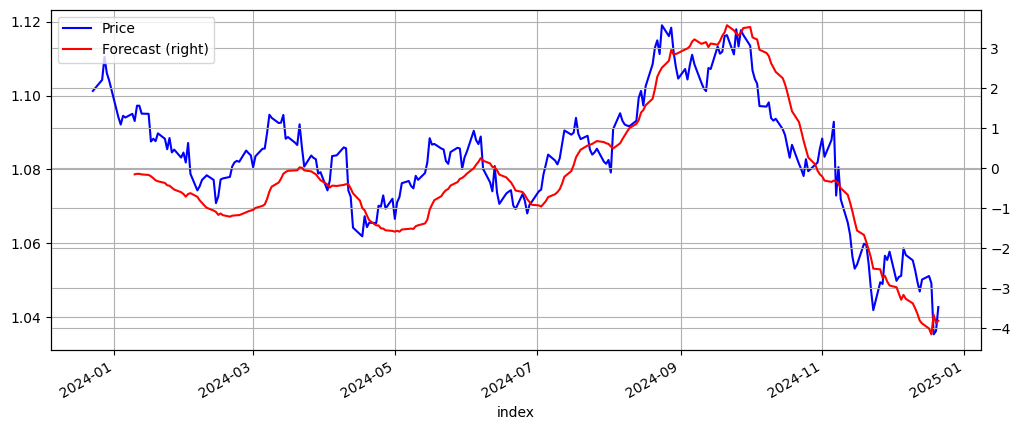

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

ax1 = price.plot(color='blue', grid=True, label='Price')
ax2 = ewmac.plot(color='red', grid=True, secondary_y=True, label='Forecast')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

The original introduction jumps directly to "Did we make any money?".  
I would like to see here the orders that were triggered by this forecast, but instead we jump directly into P&L.  Still, these are the P&L numbers for this forecast and data:

In [16]:
from systems.accounts.account_forecast import pandl_for_instrument_forecast
account = pandl_for_instrument_forecast(forecast = ewmac, price = price)
account.percent.stats()

[[('min', '-0.585'),
  ('max', '1.18'),
  ('median', '-0.001487'),
  ('mean', '-0.006259'),
  ('std', '0.1664'),
  ('skew', '1.373'),
  ('ann_mean', '-1.602'),
  ('ann_std', '2.663'),
  ('sharpe', '-0.6017'),
  ('sortino', '-0.8407'),
  ('avg_drawdown', '-1.378'),
  ('time_in_drawdown', '0.9042'),
  ('calmar', '-0.4684'),
  ('avg_return_to_drawdown', '-1.163'),
  ('avg_loss', '-0.09977'),
  ('avg_gain', '0.1039'),
  ('gaintolossratio', '1.041'),
  ('profitfactor', '0.8769'),
  ('hitrate', '0.4571'),
  ('t_stat', '-0.6075'),
  ('p_value', '0.544')],
 ('You can also plot / print:',
  ['rolling_ann_std', 'drawdown', 'curve', 'percent'])]

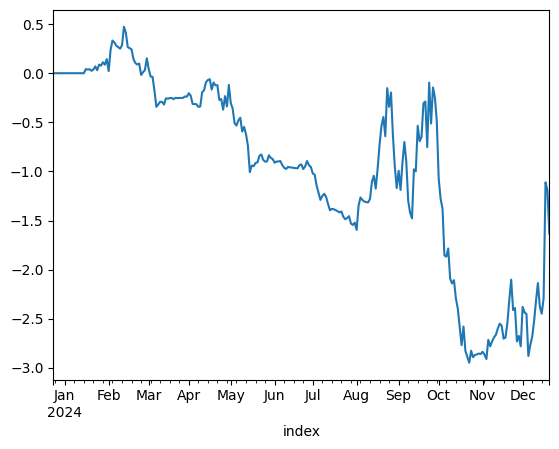

In [17]:
account.curve().plot()
plt.show()

In [18]:
conn.close_connection()

2024-12-22 23:06:02 DEBUG connectionIB {'type': 'connectionIB', 'broker': 'IB', 'clientid': 111} Terminating {'ipaddress': '127.0.0.1', 'port': 7497, 'client': 111}
